## Aladdin Tutorial

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)


# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 5

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

2025-04-13 16:35:56.626411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744562156.817805      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744562156.870184      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.50MB/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch [0/5] Batch 0/1875                       Loss D: 0.6324, loss G: 0.7325
Epoch [1/5] Batch 0/1875                       Loss D: 0.3357, loss G: 1.4876
Epoch [2/5] Batch 0/1875                       Loss D: 0.7923, loss G: 0.6102
Epoch [3/5] Batch 0/1875                       Loss D: 0.6878, loss G: 0.9766
Epoch [4/5] Batch 0/1875                       Loss D: 0.3252, loss G: 1.6980


## Another implementation

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
img_shape = (1, 28, 28)
batch_size = 128
epochs = 20
lr = 0.0002

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(z.size(0), *img_shape)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # ảnh từ [-1, 1]
])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        real = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)

        real_loss = loss_fn(discriminator(real_imgs), real)
        fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = loss_fn(discriminator(gen_imgs), real)  # muốn lừa được D

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

Epoch [1/20]  Loss D: 0.4599, Loss G: 1.4092
Epoch [2/20]  Loss D: 0.4905, Loss G: 1.0015
Epoch [3/20]  Loss D: 0.4058, Loss G: 1.5251
Epoch [4/20]  Loss D: 0.4750, Loss G: 1.5201
Epoch [5/20]  Loss D: 0.5987, Loss G: 1.9700
Epoch [6/20]  Loss D: 0.4625, Loss G: 1.3451
Epoch [7/20]  Loss D: 0.7022, Loss G: 0.4067
Epoch [8/20]  Loss D: 0.4747, Loss G: 1.1857
Epoch [9/20]  Loss D: 0.5106, Loss G: 0.9685
Epoch [10/20]  Loss D: 0.4976, Loss G: 1.5375
Epoch [11/20]  Loss D: 0.4943, Loss G: 1.0376
Epoch [12/20]  Loss D: 0.5303, Loss G: 1.1630
Epoch [13/20]  Loss D: 0.5666, Loss G: 1.1345
Epoch [14/20]  Loss D: 0.6101, Loss G: 0.9039
Epoch [15/20]  Loss D: 0.5970, Loss G: 1.1705
Epoch [16/20]  Loss D: 0.5691, Loss G: 0.6928
Epoch [17/20]  Loss D: 0.5769, Loss G: 0.8867
Epoch [18/20]  Loss D: 0.6243, Loss G: 0.8268
Epoch [19/20]  Loss D: 0.6302, Loss G: 0.7167
Epoch [20/20]  Loss D: 0.6214, Loss G: 1.3194


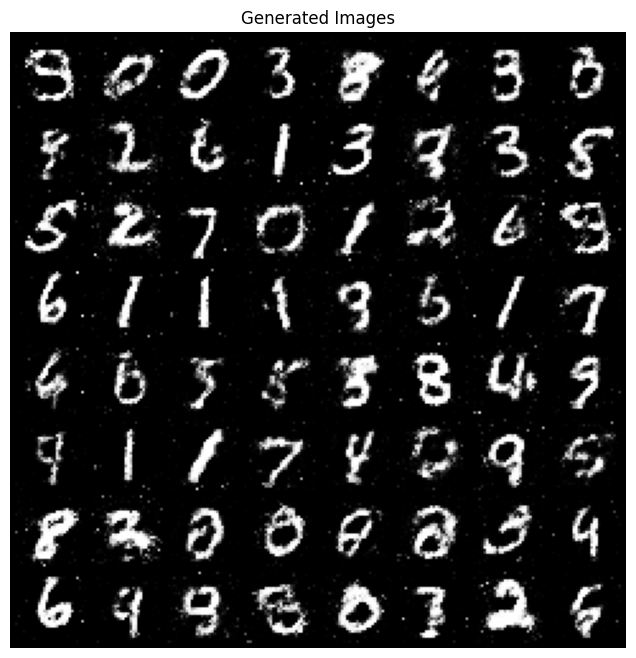

In [9]:
generator.eval()
z = torch.randn(64, latent_dim, device=device)
fake_imgs = generator(z).detach().cpu()

# Chuyển về ảnh [0, 1] để hiển thị
fake_imgs = fake_imgs * 0.5 + 0.5

grid = make_grid(fake_imgs, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Generated Images')
plt.show()